In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6
print("imports ok")

imports ok


In [ ]:
"""
Python classification
There are 3 types of input features:
    Objective: factual information;
    Examination: results of medical examination;
    Subjective: information given by the patient.
Features:
    Age | Objective Feature | age | int (days)
    
    Height | Objective Feature | height | int (cm) |
    
    Weight | Objective Feature | weight | float (kg) |
    
    Gender | Objective Feature | gender | categorical code |
    
    Systolic blood pressure | Examination Feature | ap_hi | int |
    
    Diastolic blood pressure | Examination Feature | ap_lo | int |
    
    Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal|
    
    Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
    
    Smoking | Subjective Feature | smoke | binary |
    
    Alcohol intake | Subjective Feature | alco | binary |
    
    Physical activity | Subjective Feature | active | binary |
    
    Presence or absence of cardiovascular disease | Target Variable | cardio | binary |
    """

In [ ]:
"""
Il s'agit de faire de la classification ici.
on veut faire un modèle capable de prédire si la personne aura des pbs cardio-vasculaires

"""

In [3]:
#lecture du CSV de données avec pandas :
csv = pd.read_csv(r"./data/cardio_train.csv", error_bad_lines=False, delimiter=";")
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
# la colonne des ages est trop funky, ajout d'une colonne en années pour visualisation :
csv["age_years"] = csv.age.map(lambda x: round(x/365.25, 2))

In [5]:
# IMC ou BMI est une mesure utilisée pour mesurée l'état physique des gens 
# La fonction est déclarée ici pour clarté, 
# mais elle aurait très bien marché en lambda pour aller plus vite
def calcimc(line):
    return round(line["weight"]/ ((line["height"]/100)**2),1)

In [6]:
csv["BMI"] = csv.apply(calcimc, axis=1) #axis=1 applique la fonction à chaque ligne
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.36,22.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.38,34.9
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.63,23.5
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.25,28.7
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.84,23.0


In [7]:
csv.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,53.302869,27.555311
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.754974,6.092596
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,29.560000,3.500000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,48.360000,23.900000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,53.940000,26.400000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,58.390000,30.200000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,64.920000,298.700000


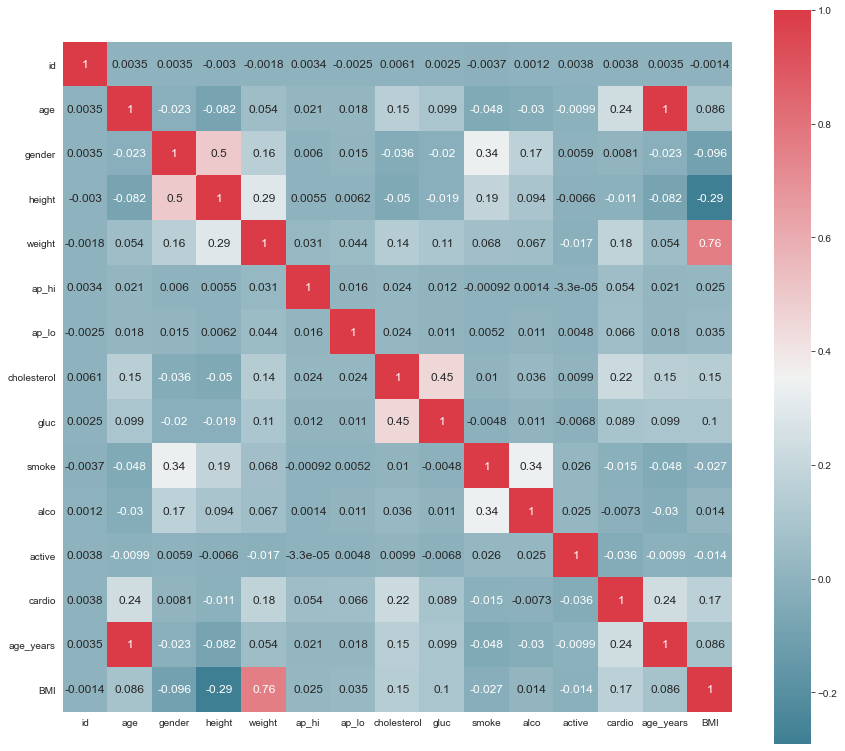

In [13]:
# représentation des corrélations entre les variables en heatmap :

corr = csv.corr()
_ , ax = plt.subplots(figsize =( 15 , 15 ))
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
    corr, 
    cmap = cmap,
    square=True, 
    cbar_kws={ 'shrink' : .9 }, 
    ax=ax, 
    annot = True, 
    annot_kws = { 'fontsize' : 12 }
)

In [ ]:
# corrélation étrange entre la taille et le genre ?

In [16]:
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.36,22.0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.38,34.9
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.63,23.5
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.25,28.7
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.84,23.0


In [20]:
# on ré-écrit la colonne gender avec des 0 et des 1 :
# il semble manquer les infos sur à quoi correspondent les catégories dans le sujet !
csv["b_gender"] = csv.gender.map(lambda x: 1 if x==1 else 0)
csv.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI,b_gender
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.36,22.0,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.38,34.9,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.63,23.5,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.25,28.7,0
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.84,23.0,1


In [ ]:
# il faut séparer la variable cholestérol en 3 colonnes binaires :